In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Sequence, Optional

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
# def append_ones(matrix):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=1)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector: NDArray) -> NDArray:
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels: NDArray) -> NDArray:
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

# MNIST dataset

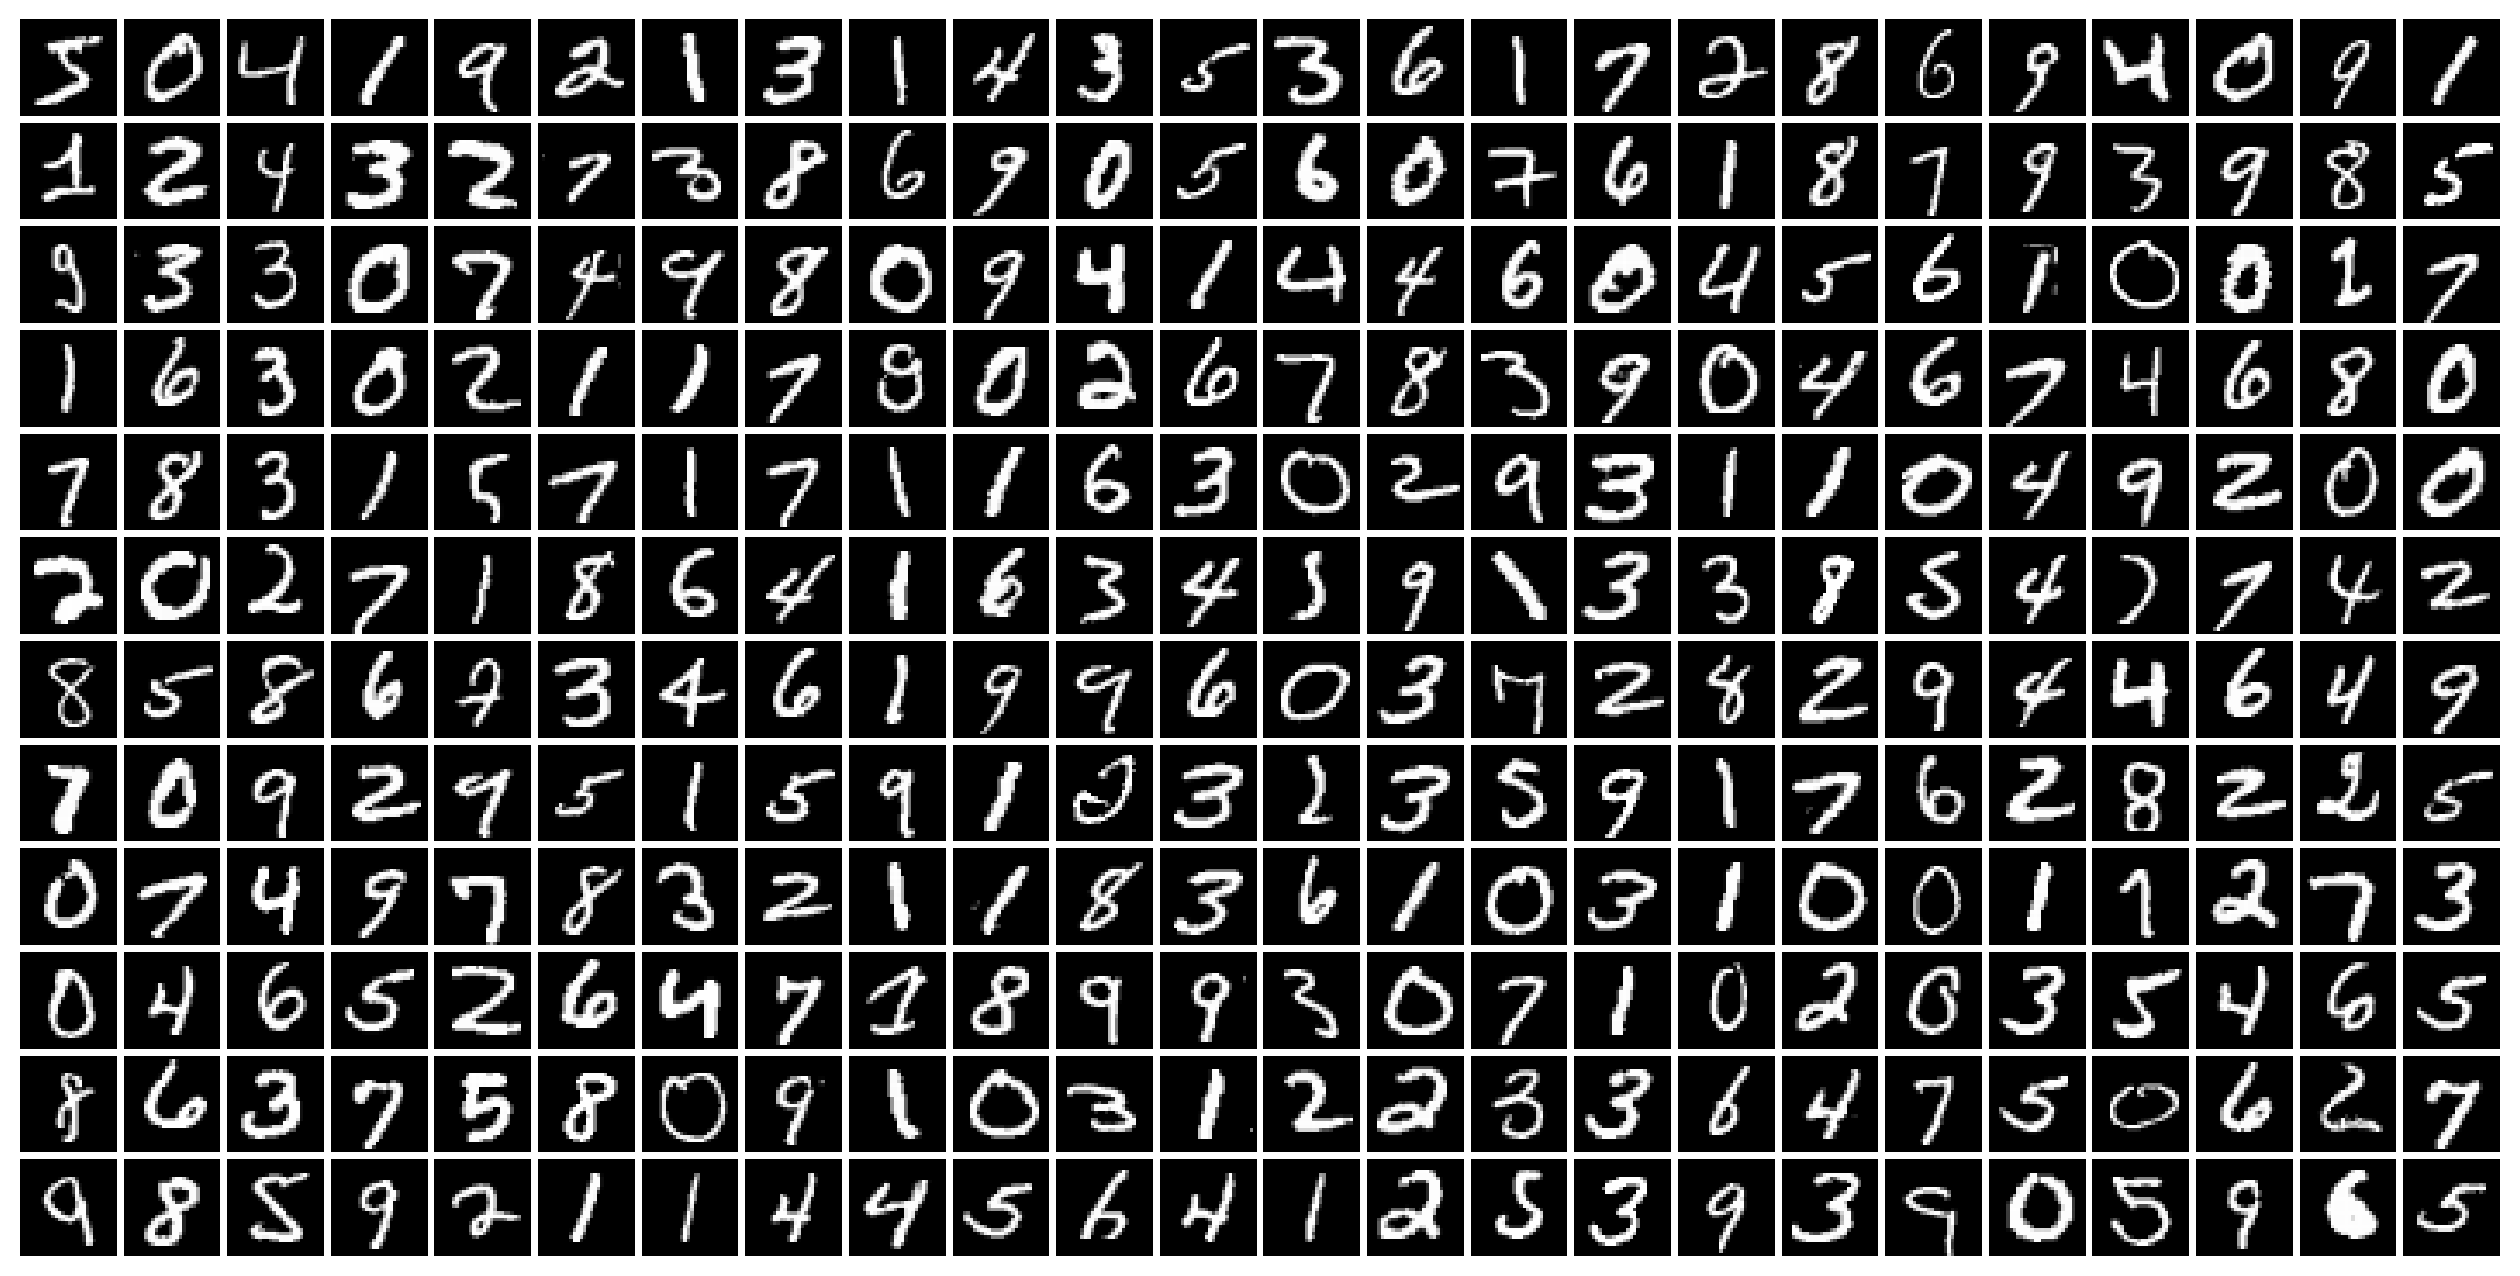

In [3]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# Backpropagation algorithm

In [4]:
class Layer(ABC):
    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self, *args, **kwargs):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params;
            * update parameters using (momentum) SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [5]:
class Sigmoid(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (self.y * (1.0 - self.y))
        # --- Propagate ∂Loss/∂x backward
        return grad_x


class Linear(Layer):
    def __init__(self, vsize: int, hsize: int, lr: float, momentum: float):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.reset()

    def reset(self):
        # Weights initialization
        scale = np.sqrt(6 / (self.vsize + self.hsize))
        self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
        # self.w = np.random.normal(0, 0.01, size=(self.vsize, self.hsize)).astype(np.float32)

        # Biases initialization
        self.b = zeros(self.hsize)

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)

        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # --- Compute  ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # --- Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # --- Propagate ∂Loss/∂x backward
        return grad_x

### Softmax activation

Implement the softmax activation function. Remember that naive sotmax implementation is numerically unstable: the numerator and the denominator may overflow. Make sure that your implementation has no overflow issues.

In [6]:
def softmax(x: NDArray) -> NDArray:
    m = x.max(axis=1, keepdims=True)
    y = np.exp(x - m)
    return y / y.sum(axis=1, keepdims=True)

### Forward pass

Calculate the total input to the neurons. Then calculate the activations (remember to add *ones* as the last column). Store the result in `layer.activations`.

##### Computing derivatives of activation function

If `compute_derivatives` is set to `True`, we also need to compute the derivatives of the activation function and store them in `layer.d_activations`. We **do not** need to add *ones column* to the derivatives matrix! *Ones* are only needed in the activations matrix, where they are used to add biases to the total input of neurons in the next hidden layer.


In [7]:
def forward_pass(mlp: Sequence[Layer], x: NDArray, training: bool) -> NDArray:
    for layer in mlp:
        x = layer.forward(x, training=training)
    return x

### Error backpropagation

Fist, we need to calculate the deltas in `prev_layer`. To calculate them we use:
 - deltas and weights from `layer`,
 - derivatives of the activation function from `prev_layer`.
 
Once *deltas* are calculated, we can use them to compute gradients.


In [8]:
def error_backpropagate(mlp: Sequence[Layer], X_batch: NDArray, grad_y: NDArray):
    for i in reversed(range(len(mlp))):
        # --- Get input to the i-th layer i.e. output of the (i-1)-th layer (or `X_batch` if i=0)
        x = mlp[i - 1].y if i > 0 else X_batch
        # --- Propagate the ∂Loss/∂y backward through layer `i` and update params
        grad_y = mlp[i].backward(x, grad_y)

### MLP training

In order to start the back propagation procedure, we need to compute *deltas* in the output layer (that is $\Delta^{\left(y\right)}$). Use network output (from the forward pass) and target labels (stored in `batch_labels`) to calculate the *deltas*. Remember that the output layer is a softmax and that we minimize cross-entropy cost.

In [9]:
def train_mlp(mlp: Sequence[Layer], dataset: NDArray, labels: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size

    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)

    for batch_idx, (X_batch, t_batch) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        # NOTE: in this implementation mlp returns *mlogits* and not probabilities
        y = forward_pass(mlp, X_batch, training=True)

        # Compute ∂Loss/∂y for the last layer i.e. the output of the whole network assuming the loss
        # function is the cross entropy function. 
        # NOTE: in this implementation mlp returns *mlogits* and thus we need to pass `y` through
        # the softmax function to compute the appropriate gradients.
        grad_y = 1 / len(X_batch) * (softmax(y) - t_batch)

        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, X_batch, grad_y)

        if batch_idx % round(batches_limit / 50) == 0:
            print("#", end="")

# MNIST digits classification

In [10]:
def classify(mlp: Sequence[Layer], X_batch: NDArray) -> NDArray:
    mlogits = forward_pass(mlp, X_batch, training=False)
    return np.argmax(mlogits, axis=1)


def run_training(
    mlp: Sequence[Layer],
    X_train: NDArray,
    t_train: NDArray,
    X_valid: NDArray,
    t_valid: NDArray,
    batch_size: int,
    epochs_count: int,
):

    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        start_time = time.time()
        train_mlp(mlp, X_train, t_train, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, X_valid)
        accuracy = np.sum(predictions == t_valid) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2%}".format(elapsed, accuracy))

    print("Training finished!")

In [11]:
def draw_layer_filters(layer: Linear):
    filters = layer.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

In [12]:
DATASET_SIZE = 20_000  # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE * DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

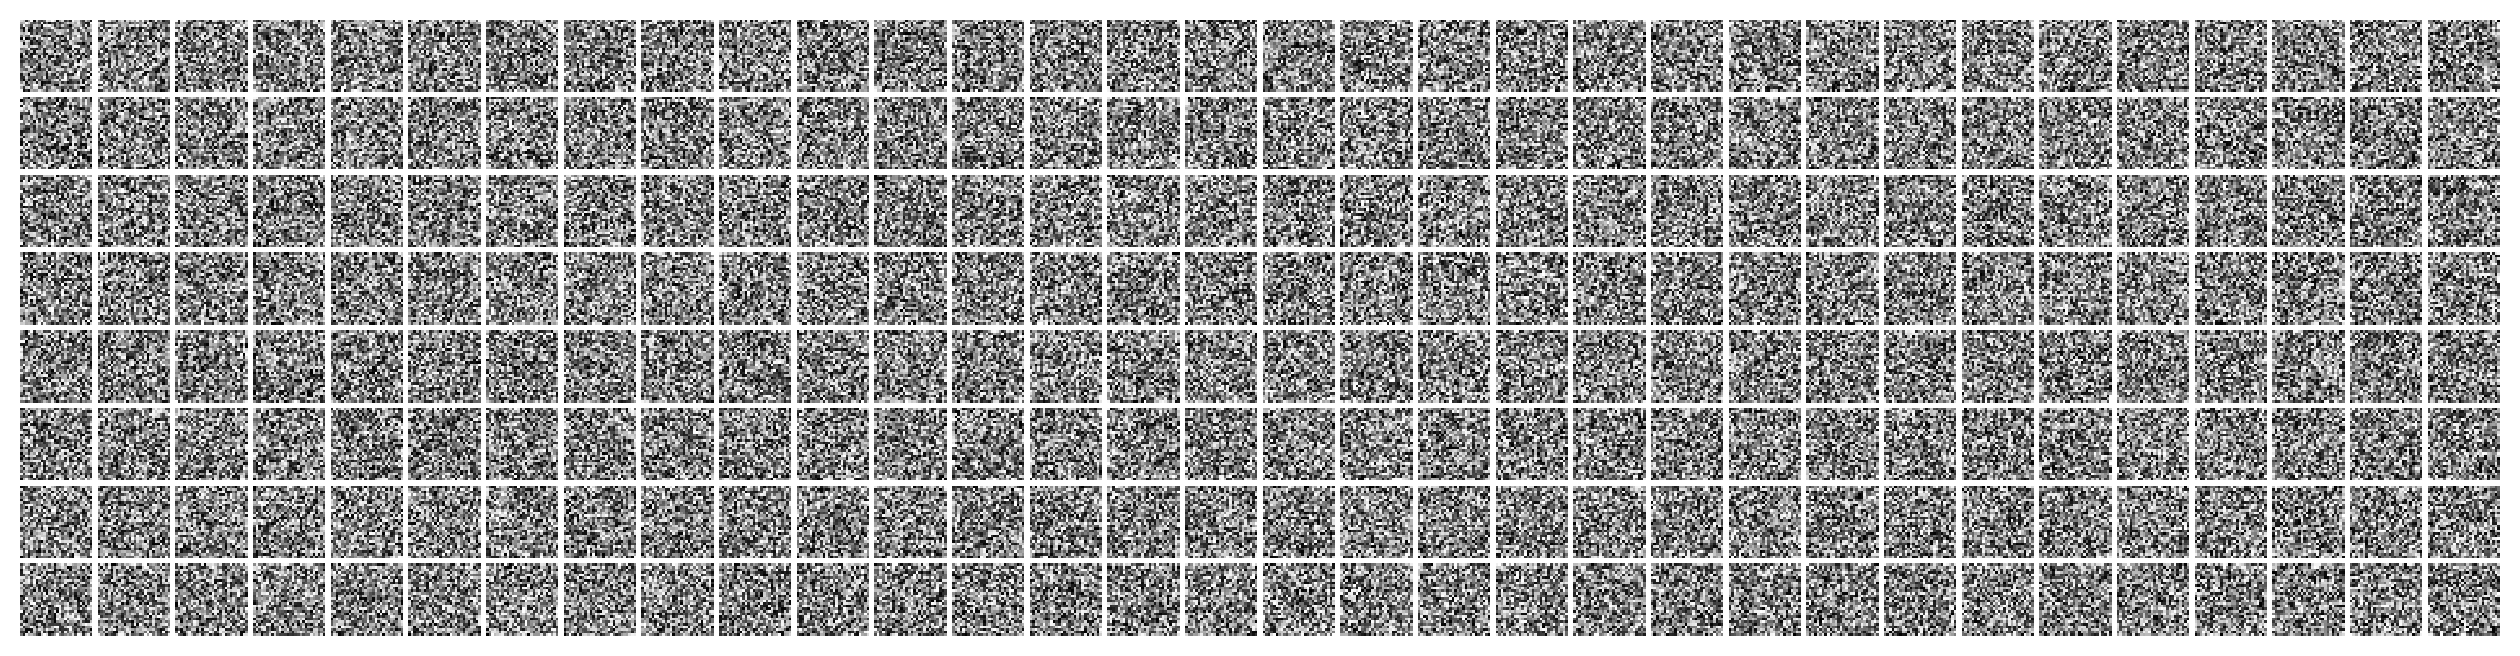

Epoch 1:	#####################################################	elapsed: 0.37s, accuracy: 87.76%
Epoch 2:	#####################################################	elapsed: 0.39s, accuracy: 90.32%
Epoch 3:	#####################################################	elapsed: 0.44s, accuracy: 91.35%
Epoch 4:	#####################################################	elapsed: 0.29s, accuracy: 91.57%
Epoch 5:	#####################################################	elapsed: 0.26s, accuracy: 92.11%
Epoch 6:	#####################################################	elapsed: 0.24s, accuracy: 92.40%
Epoch 7:	#####################################################	elapsed: 0.25s, accuracy: 92.57%
Epoch 8:	#####################################################	elapsed: 0.25s, accuracy: 92.72%
Epoch 9:	#####################################################	elapsed: 0.21s, accuracy: 93.20%
Epoch 10:	#####################################################	elapsed: 0.22s, accuracy: 93.75%
Epoch 11:	#############################

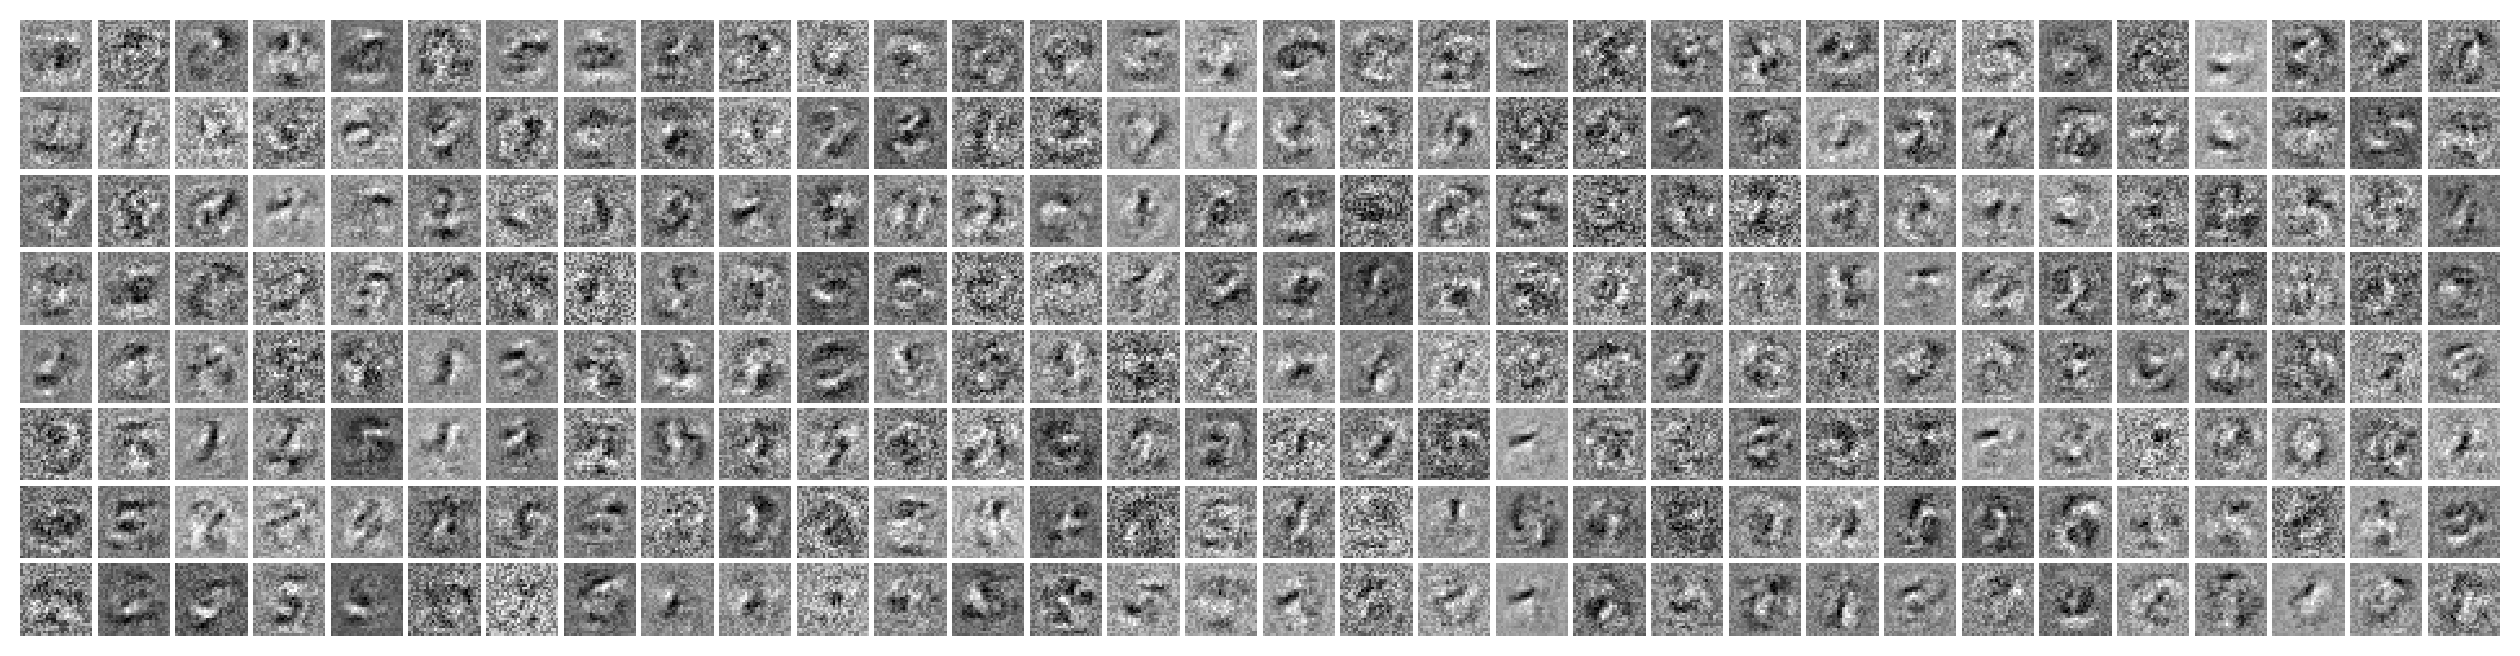

In [13]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
SOFTMAX_LEARNING_RATE = 0.15
MOMENTUM = 0.9

mlp = [
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    Sigmoid(),
    Linear(HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM),
]

draw_layer_filters(mlp[0])

run_training(
    mlp,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    BATCH_SIZE,
    EPOCHS_COUNT,
)

draw_layer_filters(mlp[0])